# Demand Modeling Using Discrete Choice Models II


The **Multinomial Logit (MNL)** model is a powerful statistical tool used to predict the probability of an individual selecting one option from a set of three or more *mutually exclusive* and *unordered* alternatives. 

For example, it can model a commuter's choice between driving, taking a bus, or riding a bike to work. The model operates on the principle that the choice is influenced by the characteristics of the alternatives (e.g., travel time or cost) and the attributes of the decision-maker (e.g., income or age). 

A key assumption of the MNL model is the **Independence of Irrelevant Alternatives** (IIA), which states that the ratio of choice probabilities between two options is unaffected by the presence of a third. 

This week, we will again use the *statsmodels library* to implement and analyze a Multinomial Logit model to understand choice behavior.

Let's import nessesary libraries.

In [1]:
import statsmodels.api as sm
from statsmodels.formula.api import logit
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt


In [2]:
### Read data as usual from the provided data file
### Do not forget to put this file in the same folder as this Jupyter Notebook

#### This week we will use trip file, let's save file location path in a variable url, as usual
urltripv = "tripv2pub.csv"

#### Read the .csv files using `pandas` libriary and store it as a `pandas` Data Frame
dtripv = pd.read_csv(urltripv)

#### Let's now check what data type we stored into `df`. This code will output object type
pd.set_option('display.max_columns', None)

Documentation and examples of **Multinomial Logit Model** can be found at the following links:

* [MNLogit](https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.MNLogit.html#statsmodels.discrete.discrete_model.MNLogit)

Feel free to read up on these sub-libraries and their use cases.

## Multinomial Logit Model

In [3]:
### For this model we need to crerate a variable with more then 2 outcomes. 


### create a list of the alternatives we will evaluate
values = ['Personal', 'Transit', 'Active', 'Other']


### create a list of conditions that defines our 3 alternatives
conditions = [
    (dtripv['TRPTRANS'] < 8)|(dtripv['TRPTRANS'] == 15)|(dtripv['TRPTRANS'] == 16) | (dtripv['TRPTRANS'] == 17),
    (dtripv['TRPTRANS'] >= 8) & (dtripv['TRPTRANS'] <= 13),
    (dtripv['TRPTRANS'] > 17) & (dtripv['TRPTRANS'] != 21),
    (dtripv['TRPTRANS'] == 13)|(dtripv['TRPTRANS'] == 14)|(dtripv['TRPTRANS'] == 21) 
    ]


# create a new column and use np.select to assign values to it using our lists as alternatives and conditions
dtripv['ModeChoice'] = np.select(conditions, values, default = 'Other')



In [4]:
# display updated DataFrame
dtripv['ModeChoice'].sample(10)

29748    Personal
13925    Personal
26076    Personal
27499    Personal
490      Personal
9938     Personal
5127     Personal
20750    Personal
4452     Personal
25759    Personal
Name: ModeChoice, dtype: object

In [5]:
dtripv.groupby(['ModeChoice']).size()

ModeChoice
Active       2407
Other         136
Personal    27536
Transit       995
dtype: int64

<Axes: xlabel='ModeChoice', ylabel='count'>

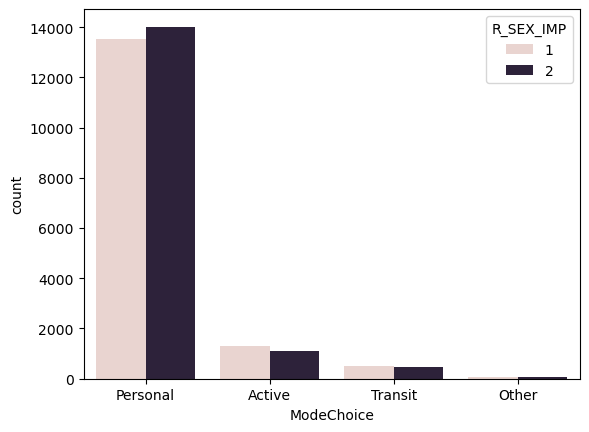

In [6]:
### Let's look at our new dependent variable
sns.countplot(x = 'ModeChoice', data = dtripv, hue ='R_SEX_IMP')

In [7]:
### Creating new variables that will be used in teh models

dtripv["PUBTRANSy"] = 0
dtripv["HHFAMINC_IMP_LOWx"] = 0
dtripv["EDUC_HIx"] = 0
dtripv["R_AGE_YAx"] = False
dtripv["R_SEX_Mx"] = 0
dtripv["PRMACT_RETx"] = False
dtripv["HHFAMINC_IMP_HIx"] = 0
dtripv["R_RACE_WHITEx"] = 0
dtripv["HHSIZE1&2x"] = False
dtripv["URBANx"] = False


dtripv.loc[:, "PUBTRANSy"] = dtripv.loc[:, 'PUBTRANS'].map({1: 1, 2: 0})

dtripv.loc[:, "HHFAMINC_IMP_LOWx"] = dtripv.loc[:, 'HHFAMINC_IMP'].map({1: 1,
                                                                        2: 1,
                                                                        3: 1,
                                                                        4: 1,
                                                                        5: 1,
                                                                        6: 0,
                                                                        7: 0,
                                                                        8: 0,
                                                                        9: 0,
                                                                        10: 0,
                                                                        11: 0})


dtripv.loc[:, "EDUC_HIx"] = dtripv.loc[:, 'EDUC'].map({1: 0,
                                                    2: 0,
                                                    3: 0,
                                                    4: 0,
                                                    5: 0,
                                                    6: 1,
                                                    7: 1,
                                                    8: 1,
                                                    -1: 0})

conditionageYA = ((dtripv['R_AGE'] > 17) & (dtripv['R_AGE'] <27))
dtripv.loc[:, "R_AGE_YAx"] = conditionageYA

dtripv.loc[:, "R_SEX_Mx"] = dtripv.loc[:, 'R_SEX_IMP'].map({1: 1, 2: 0})

dtripv.loc[:, "PRMACT_RETx"] = dtripv.loc[:, 'PRMACT'].map({-1: False, 1: False, 2: False, 3: False, 4: False, 5: True, 97: False})


dtripv.loc[:, "HHFAMINC_IMP_HIx"] = dtripv.loc[:, 'HHFAMINC_IMP'].map({1: 0, 2: 0, 3: 0, 4: 0,
                                                                       5: 0, 6: 0, 7: 0, 8: 1,
                                                                       9: 1, 10: 1, 11: 1})

dtripv.loc[:, "R_RACE_WHITEx"] = dtripv.loc[:, 'R_RACE'].map({1: 1,
                                                        2: 0,
                                                        3: 0,
                                                        4: 0,
                                                        5: 0,
                                                        6: 0,
                                                        97: 0})

dtripv.loc[:, "HHSIZE1&2&3x"] = dtripv['HHSIZE'] < 4

conditionageUR = ((dtripv['URBAN'] < 4))
dtripv.loc[:, "URBANx"] = conditionageUR

In [8]:
dtripv.describe(include='all')

,HOUSEID,PERSONID,TRIPID,SEQ_TRIPID,VEHCASEID,FRSTHM,PARK,HHMEMDRV,TDWKND,TRAVDAY,LOOP_TRIP,DWELTIME,PUBTRANS,TRIPPURP,WHYFROM,WHYTRP1S,TRVLCMIN,STRTTIME,ENDTIME,TRPHHVEH,VEHID,TRPTRANS,NUMONTRP,ONTD_P1,ONTD_P2,ONTD_P3,ONTD_P4,ONTD_P5,ONTD_P6,ONTD_P7,ONTD_P8,ONTD_P9,ONTD_P10,NONHHCNT,HHACCCNT,WHODROVE,DRVR_FLG,PSGR_FLG,WHODROVE_IMP,PARK2_PAMOUNT,PARK2_PAYTYPE,PARK2,WHYTO,WALK,TRPMILES,WTTRDFIN,WTTRDFIN5D,WTTRDFIN2D,TDCASEID,VMT_MILE,GASPRICE,WHYTRP90,NUMADLT,HOMEOWN,RAIL,CENSUS_D,CENSUS_R,HH_HISP,DRVRCNT,CDIVMSAR,HHFAMINC,HH_RACE,HHSIZE,HHVEHCNT,LIF_CYC,MSACAT,MSASIZE,URBAN,URBANSIZE,URBRUR,TDAYDATE,WRKCOUNT,STRATUMID,R_AGE,R_SEX,WORKER,DRIVER,R_RACE,R_HISP,PROXY,EDUC,PRMACT,R_SEX_IMP,VEHTYPE,HHFAMINC_IMP,ModeChoice,PUBTRANSy,HHFAMINC_IMP_LOWx,EDUC_HIx,R_AGE_YAx,R_SEX_Mx,PRMACT_RETx,HHFAMINC_IMP_HIx,R_RACE_WHITEx,HHSIZE1&2x,URBANx,HHSIZE1&2&3x
count,3.107400e+04,31074.000000,31074.000000,31074.000000,3.107400e+04,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.00000,31074.000000,31074.000000,3.107400e+04,3.107400e+04,3.107400e+04,3.107400e+04,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074.000000,31074,31074.000000,31074.000000,31074.000000,31074,31074.000000,31074,31074.000000,31074.000000,31074,31074,31074
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,2,NaN,2,NaN,NaN,1,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Personal,NaN,NaN,NaN,False,NaN,False,NaN,NaN,False,True,True
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27536,NaN,NaN,NaN,29206,NaN,24349,NaN,NaN,31074,25204,21789
mean,9.000116e+09,1.681438,2.437826,2.435702,7.619426e+11,1.048529,1.141308,0.775407,1.722276,3.810066,1.988704,95.176611,1.989026,3.156723,7.185943,26.856311,24.547821,1329.818337,1363.067613,1.041063,1.076945,3.906159,1.997265,1.243644,1.129336,0.185267,-0.226427,-0.644236,-0.880543,-0.954464,-0.976830,-0.993338,-0.999710,0.414140,1.583124,3.333526,0.986774,1.423505,3.786606,-0.802894,-0.986677,82.358853,7.43390,-0.210272,13.965150,8.166137e+06,5.815804e+06,2.302368e+06,9.000116e+13,7.527313,397.951262,5.351805,2.058506,1.654921,1.775729,5.143046,2.652346,1.924117,1.993242,53.722565,7.260636,2.677029,2.821941,2.134453,5.812737,2.292109,3.530926,1.653086,4.137478,1.188968,202211.691543,1.303694,1029.494240,46.800830,

In [ ]:
### Drop rows where 'ModeChoice' is 'Other'
df = dtripv[dtripv['ModeChoice'] != 'Other']


,HOUSEID,PERSONID,TRIPID,SEQ_TRIPID,VEHCASEID,FRSTHM,PARK,HHMEMDRV,TDWKND,TRAVDAY,LOOP_TRIP,DWELTIME,PUBTRANS,TRIPPURP,WHYFROM,WHYTRP1S,TRVLCMIN,STRTTIME,ENDTIME,TRPHHVEH,VEHID,TRPTRANS,NUMONTRP,ONTD_P1,ONTD_P2,ONTD_P3,ONTD_P4,ONTD_P5,ONTD_P6,ONTD_P7,ONTD_P8,ONTD_P9,ONTD_P10,NONHHCNT,HHACCCNT,WHODROVE,DRVR_FLG,PSGR_FLG,WHODROVE_IMP,PARK2_PAMOUNT,PARK2_PAYTYPE,PARK2,WHYTO,WALK,TRPMILES,WTTRDFIN,WTTRDFIN5D,WTTRDFIN2D,TDCASEID,VMT_MILE,GASPRICE,WHYTRP90,NUMADLT,HOMEOWN,RAIL,CENSUS_D,CENSUS_R,HH_HISP,DRVRCNT,CDIVMSAR,HHFAMINC,HH_RACE,HHSIZE,HHVEHCNT,LIF_CYC,MSACAT,MSASIZE,URBAN,URBANSIZE,URBRUR,TDAYDATE,WRKCOUNT,STRATUMID,R_AGE,R_SEX,WORKER,DRIVER,R_RACE,R_HISP,PROXY,EDUC,PRMACT,R_SEX_IMP,VEHTYPE,HHFAMINC_IMP,ModeChoice,PUBTRANSy,HHFAMINC_IMP_LOWx,EDUC_HIx,R_AGE_YAx,R_SEX_Mx,PRMACT_RETx,HHFAMINC_IMP_HIx,R_RACE_WHITEx,HHSIZE1&2x,URBANx,HHSIZE1&2&3x
357,9000014086,1,1,1,900001408601,1,2,1,2,3,2,5,2,4,1,40,15,1100,1115,1,1,4,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,1,1,1,2,1,-1.0,-1,-1,14,2,3.991920,2.694005e+06,2.725498e+06,0.000000e+00,90000140860101,3.991920,341.1,4,1,2,2,3,2,2,1,33,5,1,1,1,9,3,3,1,2,1,202202,1,1025,65,1,1,1,1,2,1,6,-1,1,4,5,Personal,0,1,1,False,1,False,0,1,False,True,True
358,9000014086,1,2,2,-1,1,2,2,2,3,2,175,2,4,14,1,15,1120,1135,2,-1,1,2,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,97,2,1,97,-1.0,-1,-1,1,1,4.300186,2.694005e+06,2.725498e+06,0.000000e+00,90000140860102,-1.000000,341.1,4,1,2,2,3,2,2,1,33,5,1,1,1,9,3,3,1,2,1,202202,1,1025,65,1,1,1,1,2,1,6,-1,1,-1,5,Personal,0,1,1,False,1,False,0,1,False,True,True
359,9000014086,1,3,3,-1,1,2,-1,2,3,2,175,2,1,1,10,5,1430,1435,2,-1,20,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,1,-1,-1,-1,-1,-1.0,-1,-1,3,-9,0.463021,2.572145e+06,2.602214e+06,0.000000e+00,90000140860103,-1.000000,341.1,1,1,2,2,3,2,2,1,33,5,1,1,1,9,3,3,1,2,1,202202,1,1025,65,1,1,1,1,2,1,6,-1,1,-1,5,Active,0,1,1,False,1,False,0,1,False,True,True
360,9000014086,1,4,4,-1,1,2,-1,2,3,2,-9,2,1,3,1,5,1730,1735,2,-1,20,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,1,-1,-1,-1,-1,-1.0,-1,-1,1,-9,0.130516,2.572145e+06,2.602214e+06,0.000000e+00,90000140860104,-1.000000,341.1,1,1,2,2,3,2,2,1,33,5,1,1,1,9,3,3,1,2,1,202202,1,1025,65,1,1,1,1,2,1,6,-1,1,-1,5,Active,0,1,1,False,1,False,0,1,False,True,True
361,9000014090,2,1,1,900001409001,1,-1,1,1,1,2,90,2,2,1,40,30,1100,1130,1,1,1,1,2,1,-1,-1,-1,-1,-1,-1,-1,-1,0,1,2,1,2,2,-1.0,-1,-1,13,-1,5.182101,1.335641e+07,0.000000e+00,1.524666e+07,90000140900201,5.182101,324.6,3,2,3,1,3,2,2,2,31,8,1,2,1,2,1,4,1,4,1,202201,2,1025,64,2,1,1,1,2,2,4,-1,2,1,8,Personal,0,0,0,False,0,False,1,1,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30922,9000217518,2,2,2,900021751801,1,-1,1,2,4,2,-9,2,4,14,1,60,1530,1630,1,1,1,1,2,1,-1,-1,-1,-1,-1,-1,-1,-1,0,1,2,1,2,2,-1.0,-1,-1,1,-9,17.366687,2.071938e+06,1.644444e+06,0.000000e+00,90002175180202,17.366687,312.0,4,2,2,2,3,2,2,2,33,6,1,2,2,10,3,2,4,6,2,202301,0,1026,72,2,2,1,1,2,2,7,5,2,1,6,Personal,0,0,1,False,0,True,0,1,False,False,True
30971,9000217625,1,1,1,-1,1,2,-1,1,1,2,20,2,3,1,50,10,1400,1410,2,-1,20,1,1,2,-1,-1,-1,-1,-1,-1,-1,-1,0,1,-1,-1,-1,-1,-1.0,-1,-1,17,-1,0.467993,8.652806e+05,0.000000e+00,1.089299e+06,90002176250101,-1.000000,298.5,8,2,2,2,3,2,2,2,34,7,1,2,2,10,4,6,4,6,2,202212,1,1026,74,1,1,1,1,2,1,6,-1,1,-1,7,Active,0,0,1,False,1,False,0,1,False,False,True
30972,9000217625,1,2,2,-1,1,2,-1,1,1,2,-9,2,3,17,1,15,1430,1445,2,-1,20,1,1,2,-1,-1,-1,-1,-1,-1,-1,-1,0,1,-1,-1,-1,-1,-1.0,-1,-1,1,-9,0.467993,8.652806e+05,0.000000e+00,1.089299e+06,90002176250102,-1.000000,298.5,8,2,2,2,3,2,2,2,34,7,1,2,2,10,4,6,4,6,2,202212,1,1026,74,1,1,1,1,2,1,6,-1,1,-1,7,Active,0,0,1,False,1,False,0,1,False,False,True
30973,9000217625,2,1,1,9

In [10]:
### Preper dependent variable
endogVar1 = df['ModeChoice']
print("Shape of array of dependent variables: ")
print(endogVar1.shape)

### Choose set of independent variables
exogVar1 = df[['HHSIZE', 'HHFAMINC_IMP_LOWx', "EDUC_HIx", "R_AGE", "R_SEX_Mx", 
                            "PRMACT_RETx", "HHFAMINC_IMP_HIx", "R_RACE_WHITEx", "URBANx"]].astype(int)

### Finally, add constant 
exogVar1 = sm.add_constant(exogVar1, prepend = True, has_constant = 'skip')
print("Shape of array of independent variables: ", exogVar1.shape)


Shape of array of dependent variables: 
(30938,)
Shape of array of independent variables:  (30938, 10)


In [11]:
endogVar1

0        Personal
1        Personal
2        Personal
3        Personal
4        Personal
           ...   
31069    Personal
31070    Personal
31071    Personal
31072    Personal
31073      Active
Name: ModeChoice, Length: 30938, dtype: object

In [12]:
exogVar1

,const,HHSIZE,HHFAMINC_IMP_LOWx,EDUC_HIx,R_AGE,R_SEX_Mx,PRMACT_RETx,HHFAMINC_IMP_HIx,R_RACE_WHITEx,URBANx
0,1.0,4,0,1,39,0,0,1,1,1
1,1.0,4,0,1,39,0,0,1,1,1
2,1.0,4,0,1,42,1,0,1,1,1
3,1.0,4,0,1,42,1,0,1,1,1
4,1.0,4,0,1,42,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
31069,1.0,2,1,1,78,0,1,0,1,1
31070,1.0,2,1,1,78,0,1,0,1,1
31071,1.0,1,0,0,58,0,0,0,1,0
31072,1.0,1,0,0,58,0,0,0,1,0


In [13]:
### Time to build the model
MNLogit_mod = sm.MNLogit(endogVar1, exogVar1, missing = 'drop')

results_MNLogit_mod = MNLogit_mod.fit()
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Parameters: ", results_MNLogit_mod.params)
print(results_MNLogit_mod.summary())
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Another summary view")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(results_MNLogit_mod.summary2())
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Marginal effects: ")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
margeff = results_MNLogit_mod.get_margeff()
print(margeff.summary())

Optimization terminated successfully.
         Current function value: 0.380912
         Iterations 8
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Parameters:                            0         1
const              2.331171  1.726070
HHSIZE             0.166426  0.136433
HHFAMINC_IMP_LOWx -0.451171  0.000986
EDUC_HIx          -0.398014 -0.684158
R_AGE              0.021811 -0.035427
R_SEX_Mx          -0.249036 -0.107463
PRMACT_RETx       -0.362054 -0.161640
HHFAMINC_IMP_HIx  -0.212460 -0.321061
R_RACE_WHITEx      0.211365 -0.257605
URBANx            -1.028513 -1.325335
                          MNLogit Regression Results                          
Dep. Variable:             ModeChoice   No. Observations:                30938
Model:                        MNLogit   Df Residuals:                    30918
Method:                           MLE   Df Model:                           18
Date:                Thu, 23 Oct 2025   Pseudo R-squ.:                 0

### How we can interpret this data?

Overall, the model is statistically significant and a good fit for this type of analysis. It successfully identifies several key demographic and household characteristics that influence the choice between Active, Personal, and Transit modes of transportation. The model explains about 7.7% of the variation in mode choice (Pseudo R-squ.: 0.077), which is a somewhat low value for a discrete choice model with this many variables.

The most intuitive way to interpret model results is by looking at the marginal effects (dy/dx), which show how the probability of choosing each mode changes for a one-unit increase in a predictor.

1. _Are There Signs of a issues in a Model?_

No, the model appears to be statistically sound and well-specified.

    Pseudo R-squared (0.077): This is a reasonable value, indicating the model has some explanatory power.

    Df Model (18): This correctly reflects the 9 predictors for each of the two non-base outcomes (9 predictors * 2 outcomes = 18).

    LLR p-value (0.000): The extremely low p-value confirms that the model as a whole is highly significant and far better than a model with no variables.


2. _Analysis of Individual Predictors (Based on Marginal Effects)_

**URBANx (Living in an Urban Area)**

This is a very strong predictor with low P-values in all three branches. Living in an urban area:

    Increases the probability of choosing Active transport by 7.31 percentage points.

    Decreases the probability of choosing Personal transport (e.g., cars) by 6.16 percentage points.

    Slightly decreases the probability of choosing Transit by 1.16 percentage points.

**R_AGE (Age)**

Age has a clear and significant (P>|z| = 0.000 in all branches) effect:

    Each additional year of age increases the probability of choosing Personal transport by 0.30 percentage points.

    Conversely, it decreases the probability of choosing Active and Transit modes by 0.14 and 0.16 percentage points, respectively. This suggests a strong shift towards personal vehicles as people get older.

**HHFAMINC_IMP_LOWx (Low Household Income)**

Low-income status is a significant factor with P>|z| = 0.000 in all branches:

    It decreases the probability of choosing Personal transport by a substantial 4.25 percentage points.

    And increase in the probability of choosing Active transport (+3.05 percentage points) and Transit (+1.20 percentage points).

**HHSIZE (Household Size)**

Household size also plays a significant role for Personal and Active Modes (P>|z| = 0.000):

    Each additional person increases the probability of choosing Personal transport by 1.20 percentage points.

    This comes at the expense of Active transport, which sees its probability decrease by 1.16 percentage points. 
    
    The effect on Transit is not statistically significant (P>|z| = 0.554).

**EDUC_HIx (Higher Education)**

Having a higher education level (P>|z| = 0.000 in all branches):

    Increases the probability of choosing Active transport by 2.88 percentage points.

    Decreases the probability of choosing Personal (-1.93 percentage points) and Transit (-0.95 percentage points) modes.


**R_SEX_Mx (Identifying as a male)**

This is a very strong predictor with low P-values in Active and Personal branches. Identifying as a male:

    Increases the probability of choosing Active transport by 1.71 percentage points.

    Decreases the probability of choosing Personal transport (e.g., cars) by 2.06 percentage points.

    Slightly decreases the probability of choosing Transit by 0.35 percentage points. However, effect is not significant at alpha = 0.05, as P>|z| = 0.077.

**PRMACT_RETx (Being retaired)**

Being retaired has a clear and significant (low P-valuesin all branches) effect:

    Being retaire decreases the probability of choosing Personal transport by 2.98 percentage points.

    Conversely, it inccreases the probability of choosing Active and Transit modes by 2.49 and 0.49 percentage points, respectively. This suggests a strong shift from personal vehicles with retairement. However, effect in Transit mode is not statistically significant (P>|z| = 0.378)

**HHFAMINC_IMP_HIx (High Household Income)**

High-income status is a significant factor with P>|z| = 0.000 in Active, 0.007 in Personal braches, but not statistically significant in Transit (0.111):

    It decreases the probability of choosing Personal transport by a substantial 1.15 percentage points.

    And increase in the probability of choosing Active transport by 1.52 percentage points.

**R_RACE_WHITEx (Identifying as an individual of white race)**

Identifying as a white person plays a significant role with low P-values in all three branches:

    It increases the probability of choosing Personal transport by 2.67 percentage points.

    This comes at the expense of Active transport, which sees its probability decrease by 1.36 percentage points and Transit mode with decrease by 1.32 percentage points. 


3. _Final Discussions and Recommendations._

This is a strong model that reveals clear patterns in transportation mode choice. The most powerful predictors appear to be urban living, age, and income level.

    Urban environments are strongly associated with a shift away from personal vehicles towards active transportation.

    Older individuals show a strong preference for personal vehicles over other modes.

    Lower-income individuals are significantly less likely to use personal vehicles, relying more on both active transport and public transit.

These findings provide a solid foundation for understanding the demographic and geographic drivers of transportation demand.

## Modeling question:

Create **3** similar logit models for mode choice with at least 3 variables that are statistically significant for three different Censys devisions:

- East North Central
- South Atlantic
- Pacific


Use the same data set without Amtrak and Airplane modes.
Discuss model results and differences between districs if any.


In [14]:
df.groupby(["CENSUS_D"]).size()

CENSUS_D
1    1775
2    3500
3    4892
4    2368
5    6258
6    1634
7    3473
8    2608
9    4430
dtype: int64

In [50]:
### Create new data set with trips from region 3 (East North Central)
df_3 = df[(df["CENSUS_D"] == 3)]

df_3.describe(include='all')


,HOUSEID,PERSONID,TRIPID,SEQ_TRIPID,VEHCASEID,FRSTHM,PARK,HHMEMDRV,TDWKND,TRAVDAY,LOOP_TRIP,DWELTIME,PUBTRANS,TRIPPURP,WHYFROM,WHYTRP1S,TRVLCMIN,STRTTIME,ENDTIME,TRPHHVEH,VEHID,TRPTRANS,NUMONTRP,ONTD_P1,ONTD_P2,ONTD_P3,ONTD_P4,ONTD_P5,ONTD_P6,ONTD_P7,ONTD_P8,ONTD_P9,ONTD_P10,NONHHCNT,HHACCCNT,WHODROVE,DRVR_FLG,PSGR_FLG,WHODROVE_IMP,PARK2_PAMOUNT,PARK2_PAYTYPE,PARK2,WHYTO,WALK,TRPMILES,WTTRDFIN,WTTRDFIN5D,WTTRDFIN2D,TDCASEID,VMT_MILE,GASPRICE,WHYTRP90,NUMADLT,HOMEOWN,RAIL,CENSUS_D,CENSUS_R,HH_HISP,DRVRCNT,CDIVMSAR,HHFAMINC,HH_RACE,HHSIZE,HHVEHCNT,LIF_CYC,MSACAT,MSASIZE,URBAN,URBANSIZE,URBRUR,TDAYDATE,WRKCOUNT,STRATUMID,R_AGE,R_SEX,WORKER,DRIVER,R_RACE,R_HISP,PROXY,EDUC,PRMACT,R_SEX_IMP,VEHTYPE,HHFAMINC_IMP,ModeChoice,PUBTRANSy,HHFAMINC_IMP_LOWx,EDUC_HIx,R_AGE_YAx,R_SEX_Mx,PRMACT_RETx,HHFAMINC_IMP_HIx,R_RACE_WHITEx,HHSIZE1&2x,URBANx,HHSIZE1&2&3x
count,4.892000e+03,4892.000000,4892.000000,4892.000000,4.892000e+03,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.0,4892.0,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4.892000e+03,4.892000e+03,4.892000e+03,4.892000e+03,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.0,4892.0,4892.000000,4892.000000,4892.000000,4892.000000,4892.00000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.00000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892.000000,4892,4892.000000,4892.000000,4892.000000,4892,4892.000000,4892,4892.000000,4892.000000,4892,4892,4892
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2,NaN,2,NaN,NaN,1,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Personal,NaN,NaN,NaN,False,NaN,False,NaN,NaN,False,True,True
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4449,NaN,NaN,NaN,4581,NaN,3836,NaN,NaN,4892,3727,3556
mean,9.000118e+09,1.644317,2.348937,2.348324,7.890742e+11,1.057236,1.200531,0.839534,1.712183,3.979967,1.991415,98.959730,1.995094,3.106705,7.241415,26.560098,24.345462,1348.133279,1379.882257,1.061938,1.193786,3.505315,1.919869,1.243254,1.154538,0.124285,-0.286795,-0.644522,-0.857114,-0.949918,-0.988553,-1.0,-1.0,0.387163,1.532706,3.942150,1.033524,1.501431,4.369787,-0.714513,-0.987939,56.244890,7.401472,-0.054374,12.583348,7.454241e+06,5.267571e+06,2.192677e+06,9.000118e+13,8.841671,378.071218,5.421913,2.025961,1.560916,1.786386,3.0,2.0,1.951554,1.984464,32.360384,6.963001,2.72363,2.775961,2.248569,5.683156,2.360384,3.403925,1.816026,4.271464,1.238144,202211.253475,1.324816,1025.236713,46.682952,1.410057,1.124898,0.85507,2.519215,1.951145,1.253884,4.673344,4.326860,1.485487,1.822567,7.179681,NaN,0.004906,0.217498,0.480581,NaN,0.514

In [16]:
### Create new data set with trips from region 5 (South Atlantic)
df_5 = df[(df["CENSUS_D"] == 5)]

df_5.describe()


,HOUSEID,PERSONID,TRIPID,SEQ_TRIPID,VEHCASEID,FRSTHM,PARK,HHMEMDRV,TDWKND,TRAVDAY,LOOP_TRIP,DWELTIME,PUBTRANS,TRIPPURP,WHYFROM,WHYTRP1S,TRVLCMIN,STRTTIME,ENDTIME,TRPHHVEH,VEHID,TRPTRANS,NUMONTRP,ONTD_P1,ONTD_P2,ONTD_P3,ONTD_P4,ONTD_P5,ONTD_P6,ONTD_P7,ONTD_P8,ONTD_P9,ONTD_P10,NONHHCNT,HHACCCNT,WHODROVE,DRVR_FLG,PSGR_FLG,WHODROVE_IMP,PARK2_PAMOUNT,PARK2_PAYTYPE,PARK2,WHYTO,WALK,TRPMILES,WTTRDFIN,WTTRDFIN5D,WTTRDFIN2D,TDCASEID,VMT_MILE,GASPRICE,WHYTRP90,NUMADLT,HOMEOWN,RAIL,CENSUS_D,CENSUS_R,HH_HISP,DRVRCNT,CDIVMSAR,HHFAMINC,HH_RACE,HHSIZE,HHVEHCNT,LIF_CYC,MSACAT,MSASIZE,URBAN,URBANSIZE,URBRUR,TDAYDATE,WRKCOUNT,STRATUMID,R_AGE,R_SEX,WORKER,DRIVER,R_RACE,R_HISP,PROXY,EDUC,PRMACT,R_SEX_IMP,VEHTYPE,HHFAMINC_IMP,PUBTRANSy,HHFAMINC_IMP_LOWx,EDUC_HIx,R_SEX_Mx,HHFAMINC_IMP_HIx,R_RACE_WHITEx
count,6.258000e+03,6258.000000,6258.000000,6258.000000,6.258000e+03,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.00000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.0,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6.258000e+03,6.258000e+03,6.258000e+03,6.258000e+03,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.0,6258.0,6258.000000,6258.000000,6258.000000,6258.00000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000,6258.000000
mean,9.000110e+09,1.666826,2.522531,2.519335,7.790603e+11,1.055289,1.166826,0.815596,1.730425,3.749121,1.987376,95.691595,1.994727,3.143816,7.269415,26.834132,25.49249,1325.781240,1362.460850,1.040428,1.092042,3.537872,2.036114,1.219080,1.118408,0.142218,-0.272132,-0.635027,-0.908277,-0.953659,-0.988814,-0.999041,-1.0,0.404602,1.631512,3.429530,1.048578,1.472036,3.815756,-0.844495,-0.990093,67.718121,7.449505,0.022851,12.111856,7.905130e+06,5.796204e+06,2.072624e+06,9.000110e+13,8.094278,372.309907,5.311441,2.048738,1.619048,1.728987,5.0,3.0,1.941834,1.996964,52.250080,7.17977,2.692074,2.784756,2.055289,5.985299,2.250080,3.511825,1.612656,3.972995,1.184564,202210.409556,1.260307,1029.197667,48.152764,1.445510,1.148290,0.849313,2.760786,1.936082,1.261266,4.798019,4.594279,1.515340,1.774688,7.335890,0.005273,0.187760,0.516299,0.484660,0.460690,0.856504
std,5.733881e+04,0.983509,2.189640,2.186383,3.069901e+11,0.228562,1.330830,0.765151,0.443774,1.956786,0.111653,166.481496,0.072431,1.491362,6.545397,27.342248,47.65137,422.717784,423.332374,0.476182,1.013965,4.549719,3.003377,0.413656,0.971815,1.330085,1.182930,0.913067,0.491148,0.348187,0.181102,0.053627,0.0,2.907215,0.920203,15.076447,0.788404,0.908082,15.885028,7.322493,0.179404,826.116838,6.571408,3.947104,37.870032,1.042849e+07,9.000487e+06,5.321120e+06,5.733881e+08,32.217819,47.541689,3.896823,0.709998,0.786230,0.444518,0.0,0.0,0.234075,0.771987,0.897462,2.80148,11.969526,1.409633,0.948647,3.320421,0.897462,1.463073,1.159701,1.691882,0.387974,17.998852,0.945617,0.398271,20.940542,0.919478,0.875171,0.637753,12.204787,0.244627,0.439359,2.451665,18.717207,0.499805,1.513157,2.342701,0.072431,0.390551,0.499774,0.499805,0.498492,0.350606
min,9.000015e+09,1.000000,1.000000,1.000000,-1.000000e+00,1.000000,-1.000000,-9.000000,1.000000,1.000000,1.000000,-9.000000,1.000000,-9.000000,-9.000000,1.000000,-9.00000,-9.000000,-9.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,0.000000,1.000000,-9.000000,-1.000000,-1.000000,-9.000000,-1.000000,-1.000000,-1.0000

In [17]:
### Create new data set with trips from region 9 (West)
df_9 = df[(df["CENSUS_D"] == 9)]

df_9.describe()

,HOUSEID,PERSONID,TRIPID,SEQ_TRIPID,VEHCASEID,FRSTHM,PARK,HHMEMDRV,TDWKND,TRAVDAY,LOOP_TRIP,DWELTIME,PUBTRANS,TRIPPURP,WHYFROM,WHYTRP1S,TRVLCMIN,STRTTIME,ENDTIME,TRPHHVEH,VEHID,TRPTRANS,NUMONTRP,ONTD_P1,ONTD_P2,ONTD_P3,ONTD_P4,ONTD_P5,ONTD_P6,ONTD_P7,ONTD_P8,ONTD_P9,ONTD_P10,NONHHCNT,HHACCCNT,WHODROVE,DRVR_FLG,PSGR_FLG,WHODROVE_IMP,PARK2_PAMOUNT,PARK2_PAYTYPE,PARK2,WHYTO,WALK,TRPMILES,WTTRDFIN,WTTRDFIN5D,WTTRDFIN2D,TDCASEID,VMT_MILE,GASPRICE,WHYTRP90,NUMADLT,HOMEOWN,RAIL,CENSUS_D,CENSUS_R,HH_HISP,DRVRCNT,CDIVMSAR,HHFAMINC,HH_RACE,HHSIZE,HHVEHCNT,LIF_CYC,MSACAT,MSASIZE,URBAN,URBANSIZE,URBRUR,TDAYDATE,WRKCOUNT,STRATUMID,R_AGE,R_SEX,WORKER,DRIVER,R_RACE,R_HISP,PROXY,EDUC,PRMACT,R_SEX_IMP,VEHTYPE,HHFAMINC_IMP,PUBTRANSy,HHFAMINC_IMP_LOWx,EDUC_HIx,R_SEX_Mx,HHFAMINC_IMP_HIx,R_RACE_WHITEx
count,4.430000e+03,4430.000000,4430.000000,4430.000000,4.430000e+03,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.0,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4.430000e+03,4.430000e+03,4.430000e+03,4.430000e+03,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.0,4430.0,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000,4430.000000
mean,9.000115e+09,1.681490,2.363205,2.361174,7.435761e+11,1.045372,1.106998,0.723928,1.718284,3.872460,1.984199,90.048533,1.990293,3.181941,7.203837,27.912641,24.328668,1325.983296,1358.681264,1.054628,1.033409,4.259594,1.793228,1.230023,1.106772,0.190068,-0.226862,-0.644018,-0.876524,-0.962528,-0.965914,-0.979233,-1.0,0.194582,1.598646,2.959368,0.954853,1.362302,3.546953,-0.772178,-0.980813,125.425508,7.552596,-0.324153,9.968859,9.660669e+06,6.706360e+06,2.928539e+06,9.000115e+13,7.196399,497.966433,5.558239,2.085779,1.698420,1.639052,9.0,4.0,1.880813,2.010835,91.971558,7.956659,3.103837,2.823476,2.181038,5.786907,1.971558,3.867494,1.335440,3.934312,1.089391,202212.849887,1.321445,1037.161400,47.109932,1.410384,1.148307,0.877201,3.773589,1.867043,1.276298,4.924153,4.467720,1.500000,1.508352,8.070429,0.009707,0.151467,0.560722,0.500000,0.595034,0.785779
std,5.707394e+04,1.021731,1.542694,1.541927,3.410981e+11,0.208143,1.353126,0.888877,0.449886,1.971514,0.124720,158.350465,0.098054,1.415917,6.727830,27.761691,43.098907,421.088787,422.989679,0.538594,1.151540,5.868228,1.705092,0.420894,0.995417,1.328939,1.226173,0.909499,0.579132,0.317254,0.301218,0.239519,0.0,1.469512,0.896091,13.925184,0.878864,1.025032,15.435089,9.355077,0.218458,1117.294987,6.699788,4.258166,25.357275,1.273395e+07,1.141561e+07,7.634555e+06,5.707394e+08,41.487091,54.087740,4.408280,0.847000,0.880676,0.480330,0.0,0.0,0.324045,0.837089,0.838024,2.759236,12.764627,1.478831,1.167290,3.271035,0.838024,1.446355,0.870418,1.581238,0.285339,22.595100,0.976613,0.469816,20.546109,1.013114,0.858670,0.632384,14.903936,0.339567,0.447216,2.414046,18.659895,0.500056,1.543176,2.421401,0.098054,0.358544,0.496355,0.500056,0.490941,0.410327
min,9.000018e+09,1.000000,1.000000,1.000000,-1.000000e+00,1.000000,-1.000000,-9.000000,1.000000,1.000000,1.000000,-9.000000,1.000000,-9.000000,-9.000000,1.000000,-9.000000,-9.000000,-9.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,0.000000,1.000000,-9.000000,-1.000000,-1.000000,-9.000000,-1.000000,-1.00000

In [51]:
### Create and report results of an Logit model with at least three independent variables for region 3
endogVar_r3 = df_3["ModeChoice"]
exogVar_r3 = df_3[['HHSIZE', 'HHFAMINC_IMP_LOWx', "EDUC_HIx"]]
exogVar_r3_const = sm.add_constant(exogVar_r3, prepend = True, has_constant = 'skip')

MNLogit_mod_r3 = sm.MNLogit(endogVar_r3, exogVar_r3_const, missing = 'drop')
results_MNLogit_mod_r3 = MNLogit_mod_r3.fit()
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Parameters: ", results_MNLogit_mod_r3.params)
print(results_MNLogit_mod_r3.summary())
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Another summary view")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(results_MNLogit_mod_r3.summary2())
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Marginal effects: ")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
margeff_r3 = results_MNLogit_mod_r3.get_margeff()
print(margeff_r3.summary())



Optimization terminated successfully.
         Current function value: 0.338301
         Iterations 8
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Parameters:                            0         1
const              2.860432 -1.919589
HHSIZE             0.085467  0.602540
HHFAMINC_IMP_LOWx -0.399789 -0.364912
EDUC_HIx          -0.535779 -2.192266
                          MNLogit Regression Results                          
Dep. Variable:             ModeChoice   No. Observations:                 4892
Model:                        MNLogit   Df Residuals:                     4884
Method:                           MLE   Df Model:                            6
Date:                Thu, 23 Oct 2025   Pseudo R-squ.:                 0.06230
Time:                        21:37:14   Log-Likelihood:                -1655.0
converged:                       True   LL-Null:                       -1764.9
Covariance Type:            nonrobust   LLR p-value:           

In [54]:
### Create and report results of an Logit model with at least three independent variables for region 5
endogVar_r5 = df_5["ModeChoice"]
exogVar_r5 = df_5[['HHSIZE', 'HHFAMINC_IMP_LOWx', "EDUC_HIx"]]
exogVar_r5_const = sm.add_constant(exogVar_r5, prepend = True, has_constant = 'skip')

MNLogit_mod_r5 = sm.MNLogit(endogVar_r5, exogVar_r5_const, missing = 'drop')
results_MNLogit_mod_r5 = MNLogit_mod_r5.fit()
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Parameters: ", results_MNLogit_mod_r5.params)
print(results_MNLogit_mod_r5.summary())
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Another summary view")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(results_MNLogit_mod_r5.summary2())
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Marginal effects: ")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
margeff_r5 = results_MNLogit_mod_r5.get_margeff()
print(margeff_r5.summary())

Optimization terminated successfully.
         Current function value: 0.343914
         Iterations 8
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Parameters:                            0         1
const              2.496863 -1.324641
HHSIZE             0.136727  0.411480
HHFAMINC_IMP_LOWx -0.157450  0.154989
EDUC_HIx          -0.229330 -2.311140
                          MNLogit Regression Results                          
Dep. Variable:             ModeChoice   No. Observations:                 6258
Model:                        MNLogit   Df Residuals:                     6250
Method:                           MLE   Df Model:                            6
Date:                Thu, 23 Oct 2025   Pseudo R-squ.:                 0.04597
Time:                        21:42:45   Log-Likelihood:                -2152.2
converged:                       True   LL-Null:                       -2255.9
Covariance Type:            nonrobust   LLR p-value:           

In [55]:
### Create and report results of an Logit model with at least three independent variables for region 9
endogVar_r9 = df_9["ModeChoice"]
exogVar_r9 = df_9[['HHSIZE', 'HHFAMINC_IMP_LOWx', "EDUC_HIx"]]
exogVar_r9_const = sm.add_constant(exogVar_r9, prepend = True, has_constant = 'skip')

MNLogit_mod_r9 = sm.MNLogit(endogVar_r9, exogVar_r9_const, missing = 'drop')
results_MNLogit_mod_r9 = MNLogit_mod_r9.fit()
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Parameters: ", results_MNLogit_mod_r9.params)
print(results_MNLogit_mod_r9.summary())
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Another summary view")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(results_MNLogit_mod_r9.summary2())
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Marginal effects: ")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
margeff_r9 = results_MNLogit_mod_r9.get_margeff()
print(margeff_r9.summary())

Optimization terminated successfully.
         Current function value: 0.427184
         Iterations 8
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Parameters:                            0         1
const              2.089484 -2.201475
HHSIZE             0.079088  0.176479
HHFAMINC_IMP_LOWx -0.482612  0.599091
EDUC_HIx          -0.366981 -1.209236
                          MNLogit Regression Results                          
Dep. Variable:             ModeChoice   No. Observations:                 4430
Model:                        MNLogit   Df Residuals:                     4422
Method:                           MLE   Df Model:                            6
Date:                Thu, 23 Oct 2025   Pseudo R-squ.:                 0.01788
Time:                        21:42:47   Log-Likelihood:                -1892.4
converged:                       True   LL-Null:                       -1926.9
Covariance Type:            nonrobust   LLR p-value:           

__Q1.__ Are There Signs of a Flawed Model? Discuss overal models' fit, what model provides better prediction? Why?

1.Region 3

`Pseudo R-squared: 0.06230 `

`Sample size: 4892 observations`

`All three mode choices (Personal, Transit, Active) are well-represented`

`Model is statistically significant (LLR p-value: 1.084e-44)`

2. Region 5

`Pseudo R-squared: 0.04597 `

`Sample size: 6258 observations`

`All three mode choices (Personal, Transit, Active) are well-represented`

`Model is statistically significant (LLR p-value: 5.038e-42)`

2. Region 5

`Pseudo R-squared: 0.01788 `

`Sample size: 4430 observations`

`All three mode choices (Personal, Transit, Active) are well-represented`

`Model is statistically significant (LLR p-value: 6.804e-13)`

The models for all regions are statistically significant (LLR p-value < 0.05), indicating that mode choice behavior is not random.

Region 3 shows the best prediction (Pseudo R² = 0.0623), followed by Region 5 (Pseudo R² = 0.0460), while the last model Region 9 (Pseudo R² = 0.0179) has very low explanatory power.

This suggests that the model for Region 3 provides better prediction performance, while the last model Region 9 may be flawed due to weak fit, possibly caused by missing variables or greater heterogeneity in travel behavior.


__Q2.__ Analysis of Individual Predictors (Based on Marginal Effects)

1. Region 3

    `HHSIZE`:
    - Active transport: Each additional household member decreases the probability of choosing Active transport by 0.55 \% points (P>|z| = 0.039).

    - Personal transport: The probability of choosing Personal transport decreases by 0.84 \% points (P>|z| = 0.007).

    - Transit: The probability of choosing Transit increases by 1.39 \% points (P>|z| = 0.000)

    `HHFAMINC_IMP_LOWx`:

    - Active transport: Probability increases by 2.28 \% points (P>|z| = 0.005).

    - Personal transport: Probability decreases by 2.32 \% points (P>|z| = 0.016).

    - Transit: No significant effect (P>|z| = 0.937).

    `EDUC_HIx`:
    
    - Active transport: Probability increases by 3.27 \% points (P>|z| = 0.000).

    - Personal transport: No significant effect (P>|z| = 0.241).

    - Transit: Probability decreases by 4.50 \% points (P>|z| = 0.000).

2. Region 5

    `HHSIZE`:
    - Active transport: household member decreases the probability of choosing Active transport by 0.82 \% points (P>|z| = 0.001).

    - Personal transport: The effect is not statistically significant (P>|z| = 0.859 > 0.05).

    - Transit: The probability of choosing Transit increases by 0.77 \% points (P>|z| = 0.000)

    `HHFAMINC_IMP_LOWx`:

    - Active transport:  No significant effect (P>|z| = 0.275 > 0.05)

    - Personal transport: No significant effect (P>|z| = 0.06 > 0.05).

    - Transit: No significant effect (P>|z| = 0.072 > 0.05).

    `EDUC_HIx`:
    
    - Active transport: Probability increases by 1.61 \% points (P>|z| = 0.011).

    - Personal transport: Probability increases by 4.13 \% points (P>|z| = 0.000).

    - Transit: Probability decreases by 5.75 \% points (P>|z| = 0.000).

3. Region 9

    `HHSIZE`:
    - Active transport: Each additional household member decreases the probability of choosing Active transport by 0.83 \% points (P>|z| = 0.021).

    - Personal transport: No significant effect (P>|z| = 0.068 > 0.05).

    - Transit: Effect is not statistically significant (P>|z| = 0.159 > 0.05).

    `HHFAMINC_IMP_LOWx`:

    - Active transport: Probability increases by 4.77 \% points (P>|z| = 0.000).

    - Personal transport: Probability decreases by 6.22 \% points (P>|z| = 0.000).

    - Transit: Probability increases by 1.45 \% points (P>|z| = 0.000).

    `EDUC_HIx`:
    
    - Active transport: Probability increases by 3.90 \% points (P>|z| = 0.000).

    - Personal transport: Probability decreases by 2.65 \% points (P>|z| = 0.017).

    - Transit: Probability decreases by 1.25 \% points (P>|z| = 0.004).

__Q3.__ Provide Final Discussion and Recommendations

These 3 model identify clear patterns in mode choice. Household size, education level, and income are 3 key predictors.

**1. Region 3:**

- Larger households may prefer to choose transit transport.

- Higher education increases the possibility of choosing active transport while decreasing reliance on personal and transit modes.

- Low-income households are somewhat less likely to use personal vehicles.

**2. Region 5:**

- Household size strongly increases the probability of choosing transit and slightly affects personal transport.

- Higher education promotes active transport and reduces transit use.


**3. Region 9:**

- Larger households slightly increase personal transport choice.

- Higher education encourages active transport and discourages personal and transit modes.

- Low-income households are more likely to choose active transport and less likely to use personal mode.

# Discussion Qestion

If you are assigned to build the model for shared bike service usage (binary choice), what independent variable you would test?
Name three different variables and define a HYPOTHESES stated what impact they will have in the form: "increased/decreased value in xxxxx will lead to lower odds / decreased probability of selecting shared bike service over other available alternatives. Justify your choices.

If I am assigned to build the model for shared bike service usage, I think the following 3 variables should be considered:

`1. Household Income:`

*HYPOTHESES*: Increased value in household income will decrease probability of selecting shared bike service over other available alternatives.

*Justification*: Higher-income individuals are more likely to own private vehicles or more comfortable travel modes, reducing their reliance on shared bikes.


`2. Age`

*HYPOTHESES*: Increased value in age (elder people) will decrease probability of selecting shared bike service over other available alternatives.

*Justification*: Younger individuals are generally more comfortable with cycling and technology (bike apps), while older users may prefer less physically and more comfortable, safer travel modes.

`3. Trip Distance`

*HYPOTHESES*: Increased trip distance will lead to a decreased probability of selecting shared bike service over other alternatives.

*Justification*: Bike is a good choice for short distance travel. For longer trip, vehicle, train, airplane may become more attractive compared with shared bike service.

# To submit your homework:

    1 - Run all code cells 

    2 - Answer all questions

    3 - Download as pdf (you can use print the page and save it as pdf)  

    4 - Inspect the pdf file (all cells are executed and all questions are answered?)

    5 - If it looks good

            - Rename it as following *WA8_first_last* replacing *first_last* with your first and last names
    
            - Upload pdf to UBLearns/BrightSpace
    
        else
    
            - Fix the issue
    
            - Repeat from step 3
    

<div class="alert alert-block alert-info">
<b>Tip:</b> you may need to install additional libriaries to enable download into pdf funciton using pip and command window, specifically: >pyppeteer-install and/or nbconvert[webpdf].
</div>